#Credit Card Fraud Detection​

Group members: Abdul Suhaib, Yifeng Liang, Michael Moon and Rodney Sibanda

## Introduction and Objective

For this project, we wanted to explore the application of machine learning techniques to address very real challenge of identifying credit card fraud. Accurate credit card fraud detection is not only important for protecting consumers, but also for providing a method for financial providers to identify and address financial fraud cases and cover their own backs. With our project, **we aimed to create a model that leverages past credit card transactional data to find fraud**, which protect consumers and financial providers alike.

In our report, we start off exploring the data and addressing any cleaning and preprocessing tasks that are found. With fraud being a binary classification problem, we chose to implement supervised learning tree based methods including Random Forest and XGBoost to model our data. We utilise our data to create train, validation, and test splits across different months of data and optimize our hyperparameters for our models using GridSearchCV. We also explore the unsupervised method of isolation forests to see how the results from this approach compare. Lastly, we explore the best model of XGBoost and summarize our findings and future steps.

## Dataset Description

The data we investigated for our project is the IEEE-CIS Fraud Detection dataset from Kaggle$^1$. This data focuses on fraud detection in real-world e-commerce and is provided by Vesta Corporation. The dataset contains a key boolean classifier of "Is Fraud" that can be used as a target variable. The data comes as two csv files: a transaction table and an identity table. The transaction table entails categorical features including product type, card related identifiers, billing addresses, purchaser and recipient email domains, and flags related to transaction characteristics.  The identity table has categorical features such as device type, device info, and various details related to device metrics. These tables can be joined cleanly using the primary key Transaction ID. The joined table contains 434 columns and 590,540 rows. To showcase the data, we loaded it in below and included the tables head:

In [ ]:
import pandas as pd
import gc

transaction_df = pd.read_csv("train_transaction.csv")
identity_df = pd.read_csv("train_identity.csv")

df = pd.merge(transaction_df, identity_df, on="TransactionID", how="left")

del transaction_df
del identity_df

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Research Question

### **Can we create a machine learning model that can accurately predict whether a transaction is fraudulent or not?**

## Data Cleaning and Preprocessing

### Reduce Memory Requirements

There were a few key steps to cleaning up this data before it could be used for any form of modelling. The first action we took was reducing the memory needs for this dataset. The data was stored as objects, int64, and float64 datatypes. We chose to convert these datatypes into smaller memory requiring datatypes where possible, as to reduce the overall memory load when preprocessing and modelling on the data. The code below was written in reference to code found online$^2$.

In [ ]:
import numpy as np

# Reduction of memory function to optimize speeds for modelling and reduce chance of kernel crashing
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
reduce_mem_usage(df)

<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-3-bc20ca611525>:22: RuntimeWarning: overflow enco

Mem. usage decreased to 645.97 Mb (67.0% reduction)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning: Initial Exploring

After addressing memory requirment issues, we dove into the data, looking at into things like NAN values and classifiers of our categorical variables that may be important to address before modelling the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 646.0+ MB


In [ ]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/na

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.00,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,0.000000,4901.170153,0.0,0.0,0.0,0.0,0.0,...,0.0,1.561523e+00,0.0,0.0,198.75,6.898438,2.373047,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.00,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.00,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.00,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.50,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.00,44.000000,26.000000,548.0000,216.00000,32.0


In [ ]:
# Checking out the categorical variables for total number of categories
cards = ["card"+str(i) for i in range(1,7)]
df[cards].nunique()

,0
card1,13553
card2,500
card3,114
card4,4
card5,119
card6,4


In [ ]:
df["ProductCD"].nunique()

5

In [ ]:
df["addr1"].nunique()

332

In [ ]:
df["addr2"].nunique()

74

In [ ]:
df["P_emaildomain"].nunique()

59

In [ ]:
df["R_emaildomain"].nunique()

60

In [ ]:
M = ["M"+str(i) for i in range(1,10)]
df[M].nunique()

,0
M1,2
M2,2
M3,2
M4,3
M5,2
M6,2
M7,2
M8,2
M9,2


We can see from above that in our categorical variables, we have over 15,000 total different classifiers for our categorical variables. We need to keep this in mind for later, as with out computing power, it is not possible to preprocess these into one hot encoded data. One hot enoding is typically ideal to use on nominal catgeorical data, but we will have to use a different approach such as label encoding as to not overload our memory requirements in preprocessing and modelling steps. We will save completing this preprocessing for later steps.

In [ ]:
# Checking NA values
missing_values1 = df.isna().sum()
columns_w_missing_values1 = missing_values1[missing_values1 > 0]
columns_w_missing_values1

,0
card2,8933
card3,1565
card4,1577
card5,4259
card6,1571
...,...
id_36,449555
id_37,449555
id_38,449555
DeviceType,449730


In [ ]:
# Tons of missing values to deal with and appears to be patterns of null counts across some columns
# Checked to see if there are specific related variables that contain the same number of null values
import numpy as np

null_df = df.isna()
null_groups = {}

for col in df.columns:

    null_count = null_df[col].sum()
    key = f"{null_count}"

    if key not in null_groups:
        null_groups[key] = []
    null_groups[key].append(col)

for key, cols in null_groups.items():
    print("Null values: " + key)
    print(cols)

Null values: 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
Null values: 8933
['card2']
Null values: 1565
['card3']
Null values: 1577
['card4']
Null values: 4259
['card5']
Null values: 1571
['card6']
Null values: 65706
['addr1', 'addr2']
Null values: 352271
['dist1']
Null values: 552913
['dist2']
Null values: 94456
['P_emaildomain']
Null values: 453249
['R_emaildomain']
Null values: 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
Null values: 280797
['D2']
Null values: 262878
['D3']
Null values: 168922
['D4']
Null values: 309841
['D5']
Null values: 517353
['D6']
Null values: 551623
['D7']
Null values: 515614
['D8', 'D9', 'id_09', 'id_10']
Null values: 76022
['D10']
Null values: 279287
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
Null values: 525823
['D12']
Null values: 528588


As we can see from above, there are clearly patterns of missing null values across many of the V columns, as well as in a few ID columns and D columns. Not much information is given on the V columns from kaggle, but it is not unlikely to assume they are derived data from similar sources. This could explain why many of the columns have the same missing null values.

### Data Preprocessing: Correlation Analysis of V columns

We will fill the null values in our categorical data columns later for cleaning (we are using tree based methods, so null values won't effect the model for our other continuous variables). For now, we will move into preprocessing. We took two approaches to attempt to reduce the data from it's original state, to see if we could improve or get equal results when compared to the whole dataset while reducing the overall memory and computing capacity for our models.

The first approach is shown below. We used correlation between V columns, in concert with V column grouped based on having the same NAN values. The idea behind this is that if each V column with the same NAN values is derived from the same factor, then it is likely that a lot of the necessary information may be stored in few of the derived columns. With this idea in mind, we wrote code that loops through each NAN group, and removes one of two V columns by an adjustable threshold correlation value.

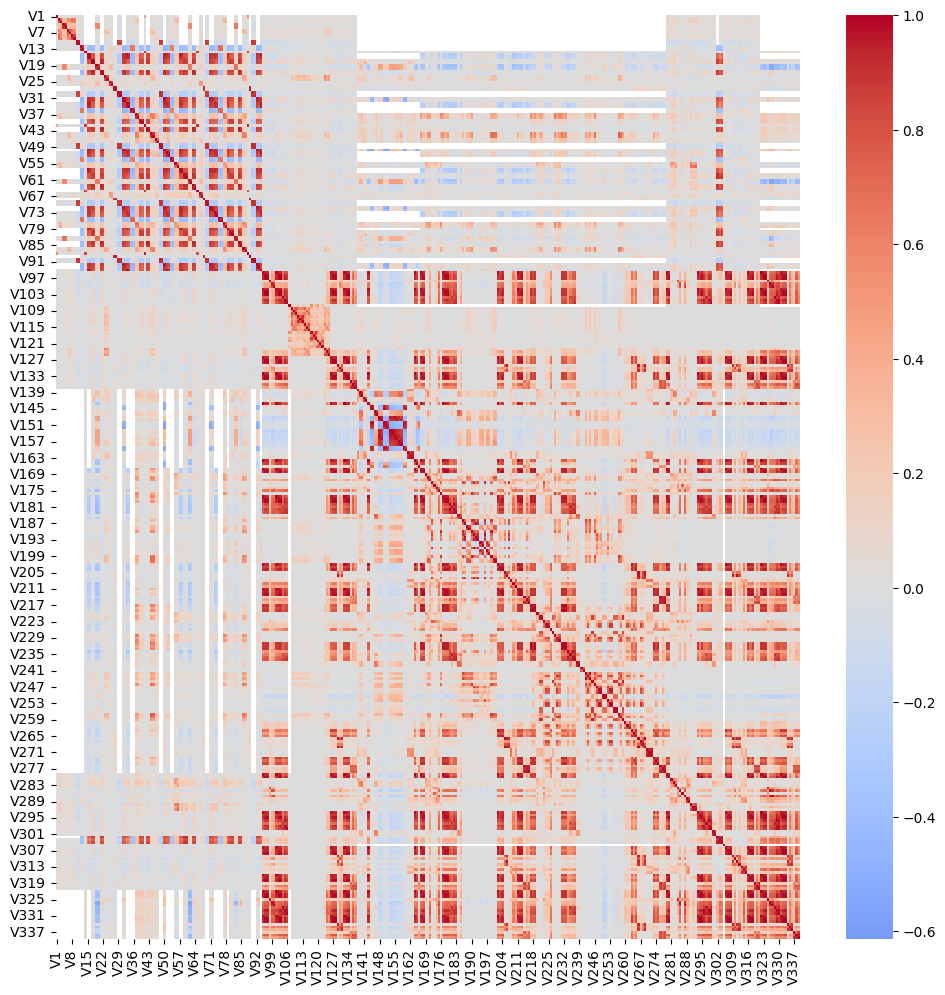

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualized correlation to see which V values are most similar
cols = ["V"+str(i) for i in range(1,340)]
corr_matrix = df[cols].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

In [ ]:
gc.collect()
# Try two methods of dimensionality reduction
# first is to remove values within groups based on high correlation
threshold = 0.9

# Find pairs of correlated features
corr_matrix_copy = corr_matrix.copy()

mask = np.triu(np.ones(corr_matrix_copy.shape), k=1).astype(bool)
corr_values = corr_matrix_copy.where(mask)
threshold_corr_pairs = [(column, row) for column in corr_values.columns for row in corr_values.index if corr_values[column][row] > threshold]

In [ ]:
# Find which V values fit into both categories (high correlation and same null value count)
col_to_drop = []

for i, j in threshold_corr_pairs:
    group1 = next((group for group, col in null_groups.items() if i in col), None)
    group2 = next((group for group, col in null_groups.items() if j in col), None)

    if group1 == group2:
        col_to_drop.append(j)

# Remove duplicates
col_to_drop = list(set(col_to_drop))
col_to_drop = sorted(col_to_drop, key=lambda x: int(x[1:]))

print(col_to_drop)

['V4', 'V10', 'V12', 'V15', 'V16', 'V17', 'V18', 'V19', 'V21', 'V27', 'V29', 'V31', 'V33', 'V35', 'V39', 'V42', 'V44', 'V48', 'V51', 'V53', 'V57', 'V58', 'V59', 'V60', 'V63', 'V69', 'V71', 'V73', 'V75', 'V79', 'V80', 'V84', 'V90', 'V92', 'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V104', 'V105', 'V111', 'V126', 'V127', 'V128', 'V132', 'V133', 'V135', 'V136', 'V139', 'V143', 'V144', 'V145', 'V146', 'V148', 'V149', 'V150', 'V151', 'V153', 'V154', 'V155', 'V156', 'V157', 'V161', 'V162', 'V167', 'V168', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V186', 'V187', 'V190', 'V191', 'V192', 'V194', 'V195', 'V196', 'V200', 'V202', 'V203', 'V204', 'V211', 'V212', 'V214', 'V217', 'V218', 'V219', 'V221', 'V222', 'V224', 'V227', 'V229', 'V231', 'V232', 'V233', 'V235', 'V236', 'V238', 'V242', 'V245', 'V246', 'V248', 'V249', 'V250', 'V253', 'V255', 'V263', 'V266', 'V270', 'V271', 'V273', 'V276', 'V277', 'V279', 'V280', 'V291', 'V293', 'V294', 'V295', 'V298', 'V300', 'V302', 'V303', 'V306', 'V307

In [ ]:
# We now can drop the designated columns to help reduce features
df_corr_reduced = df.drop(columns=col_to_drop)
df_corr_reduced.shape

(590540, 286)

### Data Preprocessing: PCA Analysis of V columns

Another approach we wanted to try in regards to reducing the V columns dimensionality was using the unsupervised learning technique of Principle Component Analysis (PCA). Our hope was that PCA could be an effective way to transforms our V columns into a smaller set of variables that would still capture the most important variance in the original data. We first tested accross differing numbers of principle components, and aimed to select a number of components that retained as much of the original variance as possible.

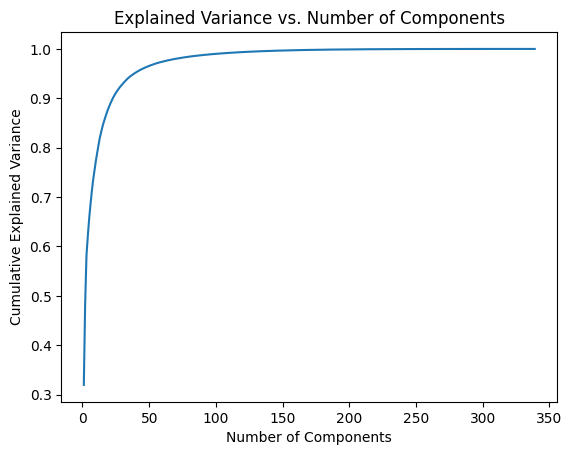

In [ ]:
# Second, we will try running a PCA on the V values with Null values filled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dfV = df[["V"+str(i) for i in range(1,340)]]
dfV = dfV.fillna(-2)
df_scaled = StandardScaler().fit_transform(dfV)
pca = PCA().fit(df_scaled)

# Plot the explained variance ratio for each component
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
# Seems like ~50 is enough n_components, so we will use this to run PCA
df_copy = df.copy()

pca = PCA(n_components=50).fit_transform(df_scaled)

df_pca = pd.DataFrame(pca)
df_copy.drop(dfV, axis=1, inplace=True)
df_pca.rename(columns=lambda x: "PCA_" + str(x), inplace=True)
df_pca_reduced = pd.concat([df_copy, df_pca], axis=1)

df_pca_reduced.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,-0.045024,0.048300,0.056854,0.012628,0.181536,-0.167985,0.126458,0.496288,0.335819,-0.236719
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.095783,0.173252,0.199942,0.074374,0.161896,-0.218850,0.091291,0.348468,0.067023,-0.252453
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,-0.099595,-0.064076,-0.061770,0.032711,0.100366,-0.132302,0.072217,0.007189,0.027657,-0.111489
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,-0.740266,0.085678,-0.648844,-1.026561,1.054276,0.582103,1.188663,-0.052836,-0.920947,-0.141513
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,-0.070060,-0.030934,-0.020249,0.107135,-0.027593,-0.133552,0.024145,0.120825,0.103854,0.091361


In [ ]:
# We now have two datasets, one from our manual feature selection and second from PCA
df_corr_reduced.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Data Cleaning: Dropping ID and Filling Categorical NAN values

In [ ]:
# drop ID from datasets
df_corr_reduced.drop("TransactionID", axis=1, inplace=True)
df_pca_reduced.drop("TransactionID", axis=1, inplace=True)
df_master = df.copy()
df_master.drop("TransactionID", axis=1, inplace=True)

In [ ]:
# Created lists for categories for label encoding
df_cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13',
       'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

missing_cats = df[df_cats].isnull().sum()
missing_cats_count = missing_cats[missing_cats > 0]
missing_cats_count

,0
card2,8933
card3,1565
card4,1577
card5,4259
card6,1571
addr1,65706
addr2,65706
P_emaildomain,94456
R_emaildomain,453249
M1,271100


In [ ]:
# Check category datatypes
df[df_cats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 49 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ProductCD      590540 non-null  object 
 1   card1          590540 non-null  int16  
 2   card2          581607 non-null  float16
 3   card3          588975 non-null  float16
 4   card4          588963 non-null  object 
 5   card5          586281 non-null  float16
 6   card6          588969 non-null  object 
 7   addr1          524834 non-null  float16
 8   addr2          524834 non-null  float16
 9   P_emaildomain  496084 non-null  object 
 10  R_emaildomain  137291 non-null  object 
 11  M1             319440 non-null  object 
 12  M2             319440 non-null  object 
 13  M3             319440 non-null  object 
 14  M4             309096 non-null  object 
 15  M5             240058 non-null  object 
 16  M6             421180 non-null  object 
 17  M7             244275 non-nul

In [ ]:
# Impute missing categorical values for correlation dataset
for col in df_corr_reduced[df_cats]:
  if df_corr_reduced[col].dtype == 'object':
    df_corr_reduced[col] = df_corr_reduced[col].fillna('Missing')
  else:
    df_corr_reduced[col] = df_corr_reduced[col].fillna(-2)

missing_cats = df_corr_reduced[df_cats].isnull().sum()
missing_cats_count = missing_cats[missing_cats > 0]
missing_cats_count

,0


In [ ]:
# Impute missing categorical values for pca dataset
for col in df_pca_reduced[df_cats]:
  if df_pca_reduced[col].dtype == 'object':
    df_pca_reduced[col] = df_pca_reduced[col].fillna('Missing')
  else:
    df_pca_reduced[col] = df_pca_reduced[col].fillna(-2)

missing_cats = df_pca_reduced[df_cats].isnull().sum()
missing_cats_count = missing_cats[missing_cats > 0]
missing_cats_count

,0


In [ ]:
# Impute missing categorical values for original dataset
for col in df_master[df_cats]:
  if df_master[col].dtype == 'object':
    df_master[col] = df_master[col].fillna('Missing')
  else:
    df_master[col] = df_master[col].fillna(-2)

missing_cats = df_master[df_cats].isnull().sum()
missing_cats_count = missing_cats[missing_cats > 0]
missing_cats_count

,0


### Data Preprocessing: Label Encoding Categories

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_pca_LE = df_pca_reduced.copy()

# Label encode the categories
le = LabelEncoder()

for col in df_corr_reduced[df_cats]:
  df_corr_reduced[col] = le.fit_transform(df_corr_reduced[col])

for col in df_pca_LE[df_cats]:
  df_pca_LE[col] = le.fit_transform(df_pca_LE[col])

for col in df_master[df_cats]:
  df_master[col] = le.fit_transform(df_master[col])

In [ ]:
# Save the new label encoded and preprocessed data that is ready for splitting and modelling
df_corr_reduced.to_csv("master_dataset_corr_features.csv", index=False)
df_pca_LE.to_csv("master_dataset_pca_features.csv", index=False)
df_master.to_csv("master_dataset_orgiinal.csv", index=False)

# # Can be used to reduce memory requirements
# del df_corr_reduced
# del df_master

### Data Preprocessing: DateTime Data

In our data preprocessing, we also had a column that gave a transactions time (TransactionDT). We wanted to utilize our new knowledge on datetime data manipulation from lecture to see if we could create a better model by including a variety of metrics that are representative of datetime from this column:

In [ ]:
# Initially in our testing it appeared PCA was best ---> went forward with PCA model with TimeSeries adjustments
# Could have adjusted this to other datasets if it showed promise to improving AUC-ROC or accuracy
from datetime import datetime, timedelta

# Add in reference start date
start_date = datetime.strptime("2017-11-30", "%Y-%m-%d")

# cleaning timestamp column
df_copy = df_pca_reduced.copy()
df_copy["TransactionDT"] = pd.to_datetime(
    df_copy["TransactionDT"].astype(int), unit='s',
    origin=start_date)

In [ ]:
# engineering features
date_features = df_copy["TransactionDT"].apply(lambda i: pd.Series({

    "hour": i.hour,
    "dayofweek": i.dayofweek,
    "quarter": i.quarter,
    "month": i.month,
    "dayofyear": i.dayofyear,
    "dayofmonth": i.day,
    "weekofyear": i.isocalendar().week

}))

df_copy = pd.concat([df_copy, date_features], axis = 1)

In [ ]:
df_copy.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,PCA_47,PCA_48,PCA_49,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,2017-12-01 00:00:00,68.5,W,13926,-2.0,150.0,discover,142.0,credit,...,0.496288,0.335819,-0.236719,0,4,4,12,335,1,48
1,0,2017-12-01 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.348468,0.067023,-0.252453,0,4,4,12,335,1,48
2,0,2017-12-01 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.007189,0.027657,-0.111489,0,4,4,12,335,1,48
3,0,2017-12-01 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,-0.052836,-0.920947,-0.141513,0,4,4,12,335,1,48
4,0,2017-12-01 00:01:46,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.120825,0.103854,0.091361,0,4,4,12,335,1,48


In [ ]:
# date range
print(df_copy["TransactionDT"].max() - df_copy["TransactionDT"].min())

earliest_date = df_copy['TransactionDT'].min()
latest_date = df_copy['TransactionDT'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

181 days 23:58:51
Earliest Date: 2017-12-01 00:00:00
Latest Date: 2018-05-31 23:58:51


In [ ]:
# Prep to create new CSV with label encoding and DT column removed in exchange for features
for col in df_copy[df_cats]:
  df_copy[col] = le.fit_transform(df_copy[col])

df_copy.drop("TransactionDT", axis=1, inplace=True)

df_copy.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,PCA_47,PCA_48,PCA_49,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0,68.5,4,10095,0,43,2,39,2,167,...,0.496288,0.335819,-0.236719,0,4,4,12,335,1,48
1,0,29.0,4,1372,304,43,3,3,2,174,...,0.348468,0.067023,-0.252453,0,4,4,12,335,1,48
2,0,59.0,4,2833,390,43,4,59,3,179,...,0.007189,0.027657,-0.111489,0,4,4,12,335,1,48
3,0,50.0,4,13341,467,43,3,15,3,283,...,-0.052836,-0.920947,-0.141513,0,4,4,12,335,1,48
4,0,50.0,1,2712,414,43,3,3,2,242,...,0.120825,0.103854,0.091361,0,4,4,12,335,1,48


In [ ]:
# Create new label encoded csv
df_copy.to_csv("master_dataset_pca+DTfeatures_LabelEncoded.csv", index=False)

### Data Preprocessing Extra: One Hot Encoding (failed)

It felt appropriate to still show our attempt at One Hot encoding for this dataset. Unfortunately, the sheer size of the dataset and number of different classifiers in categories took to much memory up to create a one hot encoded version of our dataset. Attempts were made to only one hot encode some categories that had less classifiers, but even this drastically increased comuptational times and did not highly improve upon modelling results that were obtained using label encoding.

In [ ]:
# # Convert DT and other categories that aren't card1 to OneHotEncoded
# from sklearn.preprocessing import OneHotEncoder
# # del df_pca_reduced # To have enough memory to load in new dataset

# df_cats_OHE = ['ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6',
#        'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4',
#        'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13',
#        'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
#        'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
#        'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'hour', 'dayofweek',
#         'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear']

# OHE = OneHotEncoder(sparse_output=False)
# OHE_values = OHE.fit_transform(df_copy[df_cats_OHE])
# OHE_df = pd.DataFrame(OHE_values, columns=OHE.get_feature_names_out(df_cats_OHE))

# df_copy_OHE = pd.concat([df_copy, OHE_df], axis=1)
# df_copy_OHE = df_copy_OHE.drop(df_cats_OHE, axis=1)

# df_copy_OHE.head()

In [ ]:
# df_copy.to_csv("master_dataset_pca+DTfeatures_OneHotEncoded.csv", index=False)

## Machine Learning Modeling: Random Forest


## Classifier Performance Analysis

We tested the Random Forest Classifier on three different datasets which were the Correlation Dataset, PCA Dataset, and Time Series Dataset to see which one worked best. Unfortunately, due to computational limits, we couldn’t run the model on the Original Dataset because it was too large for our available resources.

## Computational Constraints
One of the biggest challenges was the lack of computational power, which limited how many hyperparameters we could experiment with. In an ideal scenario, we would have tested a much wider range of values for n_estimators and max_depth, among other parameters, to find the best possible setup. Instead, we had to keep our search space small to ensure the model could run efficiently

## Model Performance Across Datasets
The Correlation Dataset performed the best among all tested datasets, achieving the highest accuracy (0.9804) and AUC-ROC score (0.8953).

The PCA Dataset also performed well, with an accuracy of 0.8858 and an AUC-ROC score of 0.8770. While slightly lower than the Correlation Dataset, PCA-based dimensionality reduction still retained important information for classification.

The Time Series Dataset achieved an accuracy of 0.8489 and the lowest AUC-ROC score at 0.8487. While its accuracy was competitive, the lower AUC-ROC indicates that the model struggled more with distinguishing between positive and negative classes.

## Machine Learning Modeling: XGBoost

###Classifier Performance Analysis
We tested the XGBoost Classifier on four different datasets which were the Original Dataset, Correlation Dataset, PCA Dataset, and Time Series Dataset to compare the results.

###Computational Constraints
Due to the lack of computational power, only 3 hyperparameters were tested to find the best parameters using GridSearch. These hyperparameters were n_estimators, max_depth and learning rate, and only a list of three different values of each parameter were tested.

###Model Performance Across Datasets
The Original Dataset had the best accuracy score of 0.9782 which was slightly higher than the PCA Dataset which was 0.9772. However, AUC-ROC score of the Original Dataset was higher at 0.9230 compared to the PCA Dataset which was at 0.9065.

Correlation Dataset had the third high accuracy which was lower than PCA at
 0.9763, however, it had higher AUC-ROC score at 0.9101.

The Time Series Dataset achieved both the lowest accuracy of 0.8892 and AUC-ROC score at 0.8691.

## Machine Learning Modeling: Isolation Forest

We applied the Isolation Forest algorithm to three preprocessed datasets: one with correlation-based features, one with PCA-transformed features, and one with time-based features. To maintain consistency across all models, we used a 70-30 train-test split, ensuring the same training size as other models in my analysis.

###Model Parameters

For each dataset, the Isolation Forest model was configured with:

* Contamination: "auto"

* Number of estimators: 100

* Max features per tree: 50

These parameters were held constant across all datasets for a fair comparison. We also attempted to increase the number of base estimators and features per tree, but the accuracy and ROC AUC scores showed only marginal changes.

###Best Model Performance Across Datasets

Among the three datasets, the PCA-transformed dataset achieved the highest accuracy (0.94) while maintaining a comparable ROC AUC score (0.613). Although the correlation-based dataset had a slightly better ROC AUC (0.619), the PCA dataset's overall balance of precision, recall, and accuracy makes it the best-performing model.

###Computational Constraints

Due to computational limits, we couldn’t run the model on the Original Dataset because it was too large for our available resources.

## Model Evaluation and Interpretation

###Best Model
The best model selected for our project is XGBoost model, and best Dataset was the Original Dataset, with hyperparameters fine-tuned using GridSearchCV on a limited search space due to computational constraints. The best values for n_estimators was 100 among 100, 300 and 500, max_depth was 10 among 3, 6 and 10, and learning_rate was 0.1 among 0.01, 0.1 and 0.3.

###Classification Report Highlights:

Precision (Class 1): 0.94

Recall (Class 1): 0.52

F1-score (Class 1): 0.67

Despite strong precision, the recall for the minority class which was fruad was relatively low at 0.52, indicating that many fraudulent cases were missed. This is typical in imbalanced datasets, and we might try applying SMOTE or other resampling techniques, using class weighting and exploring threshold tuning based on ROC curves.

## Future Steps

The next steps in this modeling process would be looking into other methods to potentially improve upon the model past feature reduction, model selection, and model optomization. The first idea that stands out would to try out some feature engineering.

Feature engineering could be an effective next step in helping our model identify individual card holders. Our current model is good at identifying cases where a cardholder has not committed fraud, but still misses many cases where fraud was detected. If we could find a way to link the variables between transaction and identity tables through designed features, we may improve the model. If our model was able to be fed unique identifers for each individual card holder and build an understanding of their patterns, it would be significantly easier to detect when a transaction does not follow their typical trends.

There are many ideas of features that we could try to implement that may be useful. Implementing an extra few columns that tracking the amount someone spends in an average transaction against their unique categorical identifiers could head useful when compared to the amount actually spent in a transaction. If the transaction drastically differs, this would be a good warning sign of fraud. We could consider many variations of this too, utilizing tools like target encoding and frequency encoding to see if transactions are lining up with regular spending habits of credit card holders.

## Conclusion



Through extensive data preprocessing and experimentation with multiple models—including Random Forest, XGBoost, and Isolation Forest, we identified the XGBoost model trained on the Original Dataset as the best-performing approach. Despite computational constraints limiting our hyperparameter tuning, our results demonstrated high accuracy and AUC-ROC scores, reinforcing the effectiveness of tree-based models in fraud detection. However, our findings highlighted challenges associated with imbalanced datasets, particularly the trade-off between precision and recall.  While our best model achieved strong precision (0.94), its recall (0.52) indicated that fraudulent transactions were still being missed. Additionally, leveraging more computational resources would enable a broader hyperparameter search and potentially improve model performance.

Overall, this project highlights the effectiveness of machine learning in detecting financial fraud and improving fraud prevention.

## References

1. *IEEE-CIS Fraud Detection*. Kaggle. (n.d.). https://www.kaggle.com/competitions/ieee-fraud-detection

2. Kyakovlev. (2019, August 28). *IEEE - Fe with some EDA*. Kaggle. https://www.kaggle.com/code/kyakovlev/ieee-fe-with-some-eda

3. https://koshurai.medium.com/understanding-log-loss-a-comprehensive-guide-with-code-examples-c79cf5411426

4. GeeksforGeeks. (2024b, July 15). What is Isolation Forest? https://www.geeksforgeeks.org/what-is-isolation-forest/

5. Github repositry code: https://github.com/Danny9833/fraud_detection.git
